# Microcanonical Monte Carlo

## setup

In [1]:
include("../src/ising.jl")
using CairoMakie
import LsqFit as lsq
using JLD2
using ProgressMeter
import StatsBase as sb
import Distributions as dist

In [2]:
function creutz_step(grid::Array{Int,3}; E_max::Float64=10*J, E_daemon::Float64=0.0, J::Float64=1.0, B::Float64=0.0)
    N1, N2, N3 = size(grid)
    i, j, k = rand(1:N1), rand(1:N2), rand(1:N3)
    dE = energy_diff(grid, (i, j, k), J=J, B=B)

    if E_max >= E_daemon - dE && E_daemon - dE >= 0
        grid[i, j, k] *= -1
        dM = 2*grid[i, j, k]
        E_daemon -= dE
    else 
        dE = 0
        dM = 0
    end

    return grid, E_daemon, dE, dM
end


function increase_energy(grid::Array{Int,3}, E_max::Float64 ; J::Float64=1.0, B::Float64=0.0)
    L, _, _ = size(grid)
    E = energy(grid, J, B)
    while E < E_max
        i, j, k = rand(1:L), rand(1:L), rand(1:L)
        dE = energy_diff(grid, (i, j, k), J=J, B=B)
        if dE > 0
            grid[i, j, k] *= -1
            E += dE
        end
    end
    return grid, E
end

increase_energy (generic function with 1 method)

In [3]:
function get_temperature(E_daemon::Vector{Float64}; J::Float64=1.0, E_max::Float64=10*J, verbose::Bool=false)
    Ed_dist = dist.fit(dist.Histogram, E_daemon, -2J:4J:E_max)
    weights = Ed_dist.weights
    pos = Ed_dist.edges[1][1:end-1] .+ Ed_dist.edges[1][2:end] ./ 2

    relevant = weights .> 0

    linfit(x,p) = p[1]*x .+ p[2]
    fit = lsq.curve_fit(linfit, pos[relevant], log.(weights[relevant]), [1.0, 1.0])
    m, c = fit.param
    
    T_fit = -1/m
    T_avg = 4.0 / log(1 + 4.0 / mean(E_daemon)) 

    verbose && println("T_fit = $T_fit, T_avg = $T_avg")
    return (T_fit + T_avg) / 2
end

get_temperature (generic function with 1 method)

In [4]:
function creutz_simulate(; grid_size::Int=10, E_daemon::Float64=0.0, J::Float64=1.0, B::Float64=0.0, E_0::Float64=-J*grid_size^3, E_max::Float64=0.0, N_Sample::Int=500, N_Subsweep::Int=3*grid_size^3)
    
    grid = ones(Int, (grid_size, grid_size, grid_size))
    grid, E_0 = increase_energy(grid, E_0, J=J, B=B)

    energies, mag = Array{Float64}(undef, N_Sample), Array{Float64}(undef, N_Sample)
    daemon_energies = Array{Float64}(undef, N_Sample*N_Subsweep)

    E = E_0 / grid_size^3
    M = sum(grid)

    for i in 1:N_Sample
        for j in 1:N_Subsweep
            grid, E_daemon,  dE, dM = creutz_step(grid,E_max=E_max, E_daemon=E_daemon, J=J, B=B)
            daemon_energies[(i-1)*N_Subsweep + j] = E_daemon
            E += dE/grid_size^3
            M += dM
        end
        energies[i] = E
        mag[i] = abs(M)/grid_size^3
    end
    return daemon_energies, (mean(energies), std(energies)) , (mean(mag), std(mag))
end

function creutz(; L::Int=10, E_max::Float64=10*J*L^3, E_daemon::Float64=0.0, J::Float64=1.0, B::Float64=0.0, N_Sample::Int=1_000, N_Subsweep::Int=3*L^3,)
    E_0_min, E_0_max = -3*J*L^3, -0.5*J*L^3

    # E_0_Steps = 10
    # E_0_arr = collect(range(E_0_min, E_0_max, E_0_Steps))

    E_0_delta = 0.1*J*L^3
    E_0_arr = collect(E_0_min:E_0_delta:E_0_max)
    
    daemon_energies = Float64[]
    energies, magnetisations = Float64[], Float64[]
    emergies_err, magnetisations_err = Float64[], Float64[]
    temps = Float64[]
    for E_0 in E_0_arr
        E_d, E, M = creutz_simulate(grid_size=L, E_0=E_0, E_max=E_max, E_daemon=E_daemon, J=J, B=B, N_Sample=N_Sample, N_Subsweep=N_Subsweep)
        append!(daemon_energies, E_d) # E_d is an array
        push!(energies, E[1])
        push!(emergies_err, E[2])
        push!(magnetisations, M[1])
        push!(magnetisations_err, M[2])
        temp = get_temperature(E_d, J=J, E_max=E_max)
        push!(temps, temp)
    end
    return (energies, emergies_err), (magnetisations, magnetisations_err), daemon_energies, temps
end

creutz (generic function with 1 method)

## Simulate

### test with single energy level

In [5]:
E_max = 50.0
dmn, nrg, mag = creutz_simulate(E_max=E_max)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (-1.002912, 0.004747771969814341), (0.276232, 0.10811473427583805))

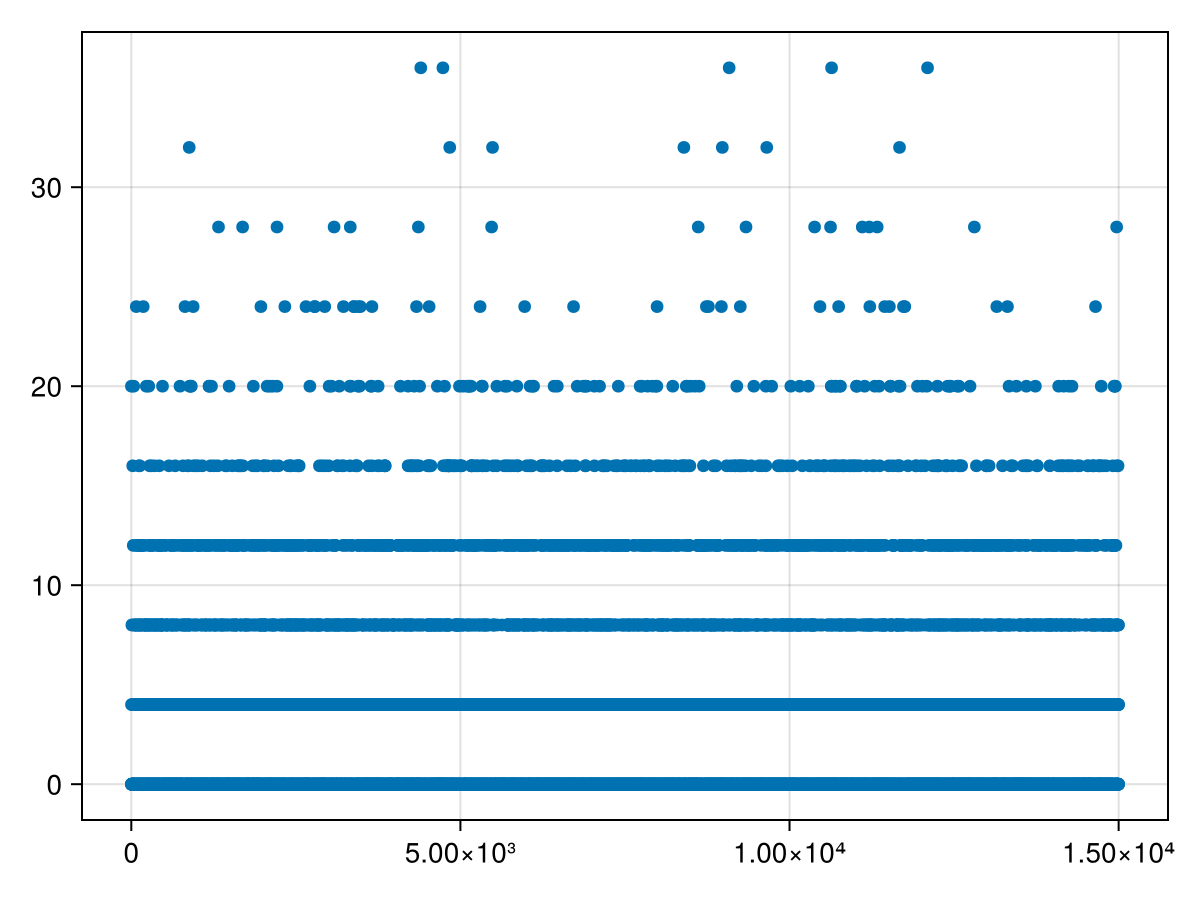

In [6]:
fig = Figure()
ax = Axis(fig[1, 1])
# only plot every 100th point
plot!(ax,dmn[1:100:end])
fig

In [7]:
linfit(x, p) = x .* p[1] .+ p[2]

function daemon_temp_plot(daemon_energies::Vector{Float64}, E_max::Float64)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="daemon energy", ylabel="log(prob)")
    dmn_hist = sb.fit(sb.Histogram, daemon_energies, nbins=floor(E_max/4)+1)
    dmn_val = dmn_hist.edges[1][1:end-1]
    dmn_prob = dmn_hist.weights ./ sum(dmn_hist.weights)
    
    plot!(ax, dmn_val, log.(dmn_prob))
    
    fit = lsq.curve_fit(linfit, dmn_val, log.(dmn_prob), [1.0, 1.0])
    lines!(ax, dmn_val, linfit(dmn_val, fit.param), color=:red)
    
    println("T= ", -1/fit.param[1])
    
    return fig
end

daemon_temp_plot (generic function with 1 method)

T_fit = 6.615459683832492, T_avg = 4.493021694602812
T= 4.350758109569366


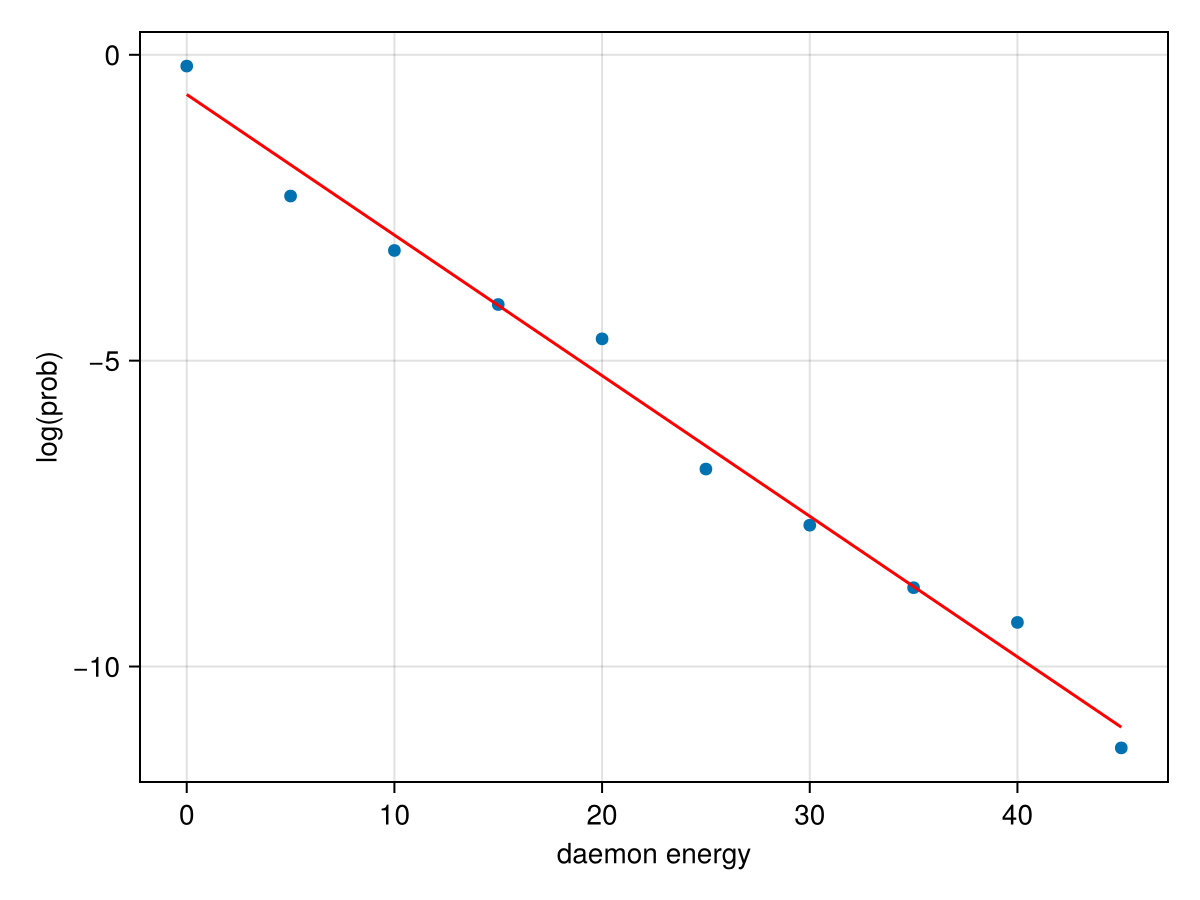

In [8]:
get_temperature(dmn, J=1.0, E_max=E_max, verbose=true)
daemon_temp_plot(dmn, E_max)

### Full Creutz algorithm

In [9]:
energies, mags, daemon_energies, temps = creutz(E_max=50.0)

(([-3.0, -2.892871999999997, -2.801148000000002, -2.701443999999999, -2.597700000000001, -2.4939440000000004, -2.393951999999998, -2.2979040000000004, -2.198039999999999, -2.0942399999999997  …  -1.3987560000000003, -1.2987320000000004, -1.2026280000000011, -1.0948080000000002, -0.9989040000000003, -0.8948760000000006, -0.8029119999999996, -0.7031480000000003, -0.6040960000000001, -0.5048560000000002], [0.0, 0.002149473478839932, 0.0024232143875373416, 0.002915366763095748, 0.00330589306072186, 0.003160831355016409, 0.003367051088568906, 0.003609406019251899, 0.0033623958282310734, 0.0037635840052487983  …  0.004167232874441967, 0.004329771694087687, 0.004024650769174121, 0.0042034277446870464, 0.004348988123425694, 0.004174452065846496, 0.004559500525830115, 0.004659593094660502, 0.005535831412663276, 0.006161268150732062]), ([1.0, 0.9816419999999992, 0.964554, 0.9454300000000001, 0.9242539999999999, 0.9022320000000006, 0.879768, 0.8573279999999998, 0.8329720000000002, 0.8054759999999

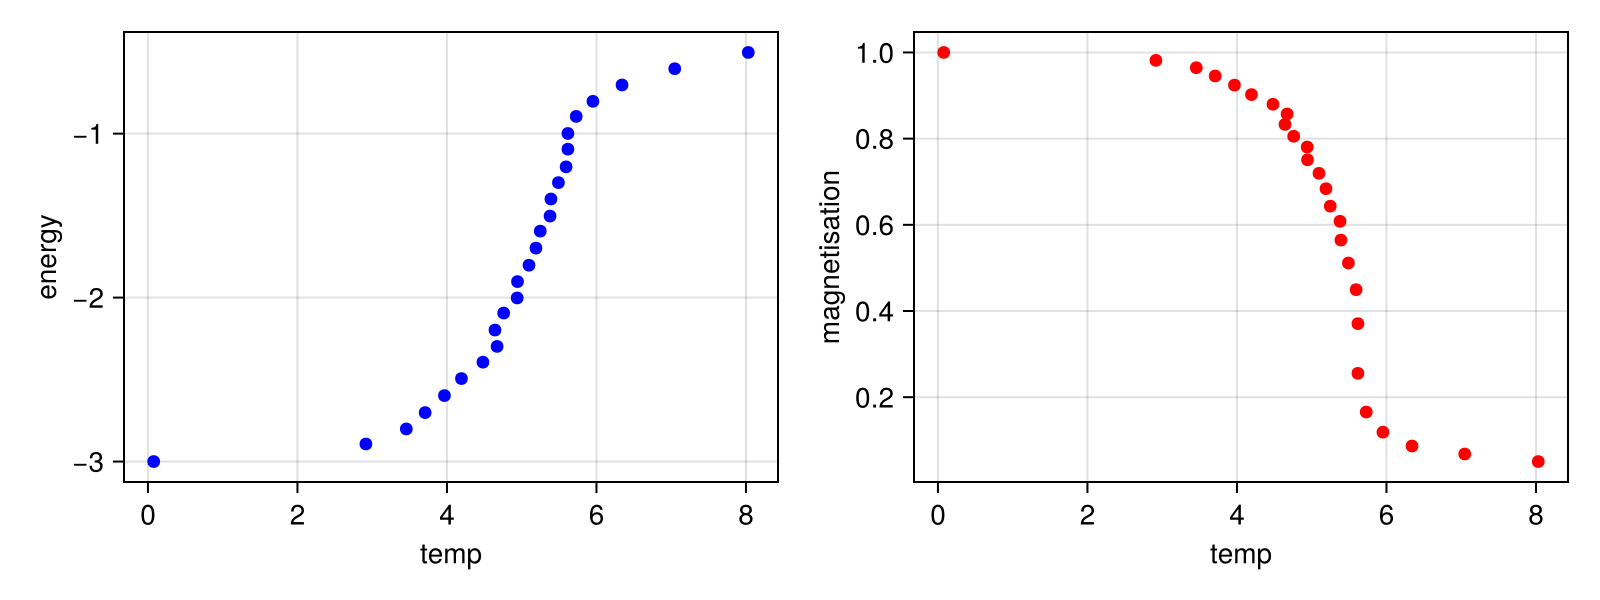

In [10]:
fig = Figure(size=(800, 300))
ax1 = Axis(fig[1, 1], xlabel="temp", ylabel="energy")
ax2 = Axis(fig[1, 2], xlabel="temp", ylabel="magnetisation")
plot!(ax1, temps, energies[1], color=:blue)
plot!(ax2, temps, mags[1], color=:red)
fig

### Vary E_max

In [11]:
emx = [6.0, 8.0, 12.0, 20.0, 60.0, 120.0, 300.0]
e_emx, m_emx, t_emx = Vector{Vector{Float64}}(undef, length(emx)), Vector{Vector{Float64}}(undef, length(emx)), Vector{Vector{Float64}}(undef, length(emx))
Threads.@threads for (i, E_max) in collect(enumerate(emx))
    e, m, dmn, t = creutz(E_max=E_max, E_daemon=0.0)
    e_emx[i] = e[1]
    m_emx[i] = m[1]
    t_emx[i] = t
end

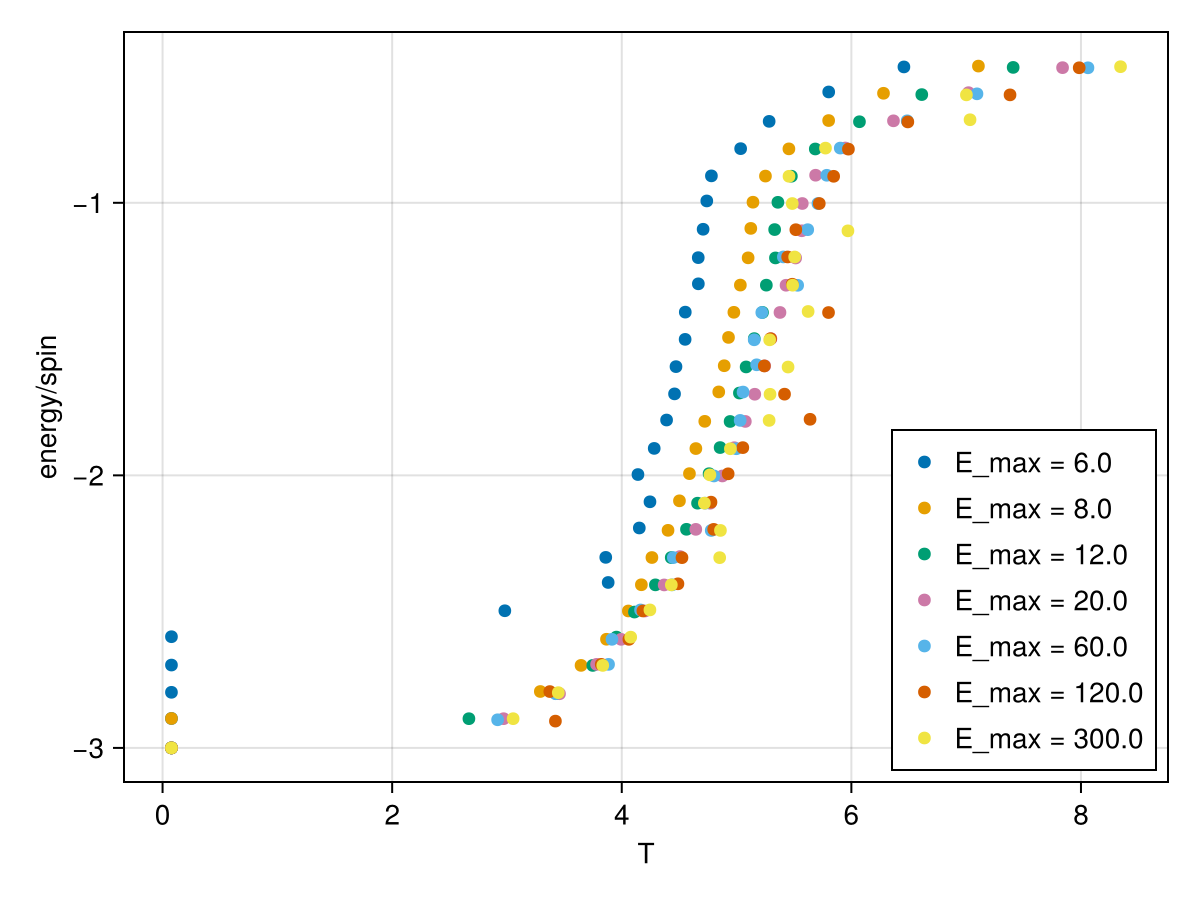

In [12]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="energy/spin")
for (t, e, E_max) in zip( t_emx,e_emx, emx)
    plot!(ax, t, e, label="E_max = $E_max")
end
axislegend(ax, position=:rb)
fig

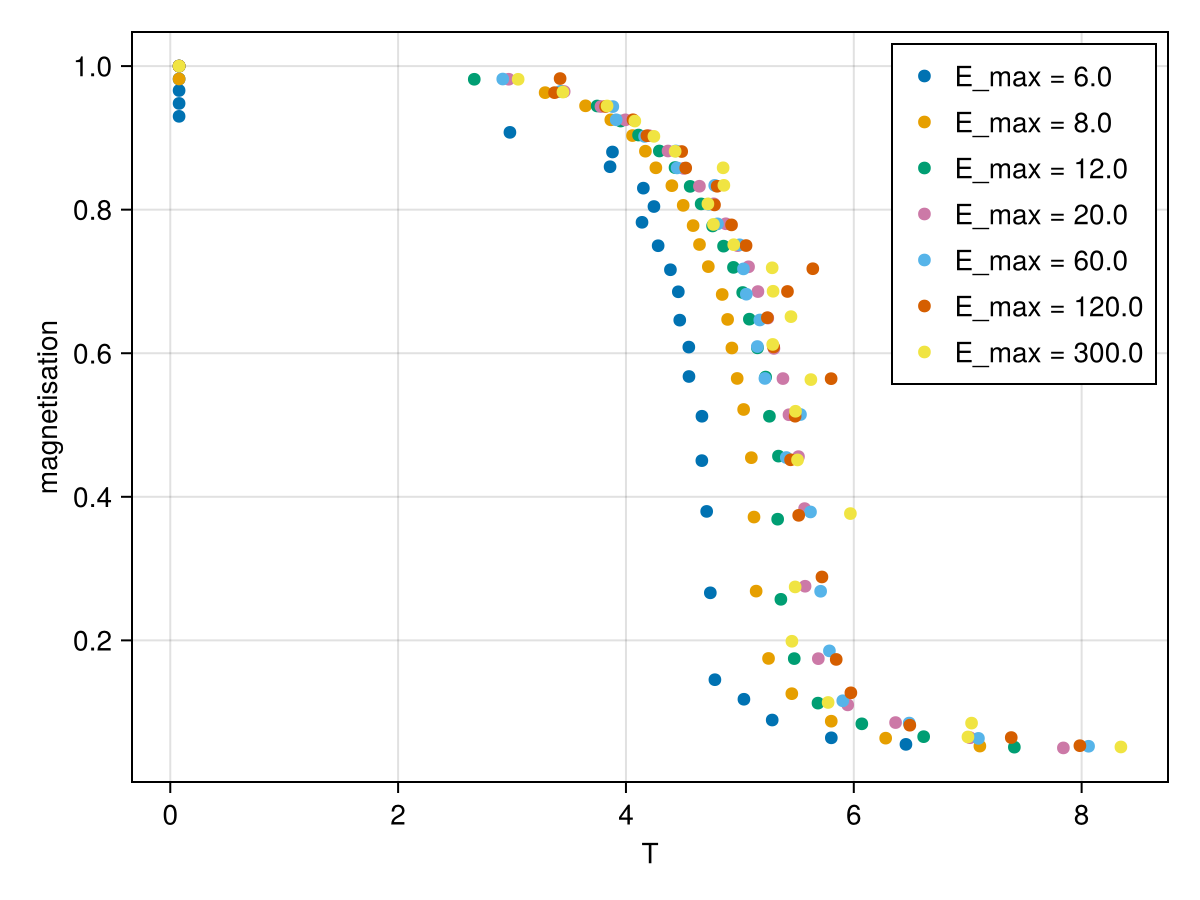

In [13]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="magnetisation")
for (t, m, E_max) in zip( t_emx,m_emx, emx)
    plot!(ax, t, m, label="E_max = $E_max")
end
axislegend(ax, position=:rt)
fig

### Vary grid size

In [14]:
grid_sizes = [6, 10, 14, 18,]
e_gs, m_gs, t_gs = Vector{Vector{Float64}}(undef, length(grid_sizes)), Vector{Vector{Float64}}(undef, length(grid_sizes)), Vector{Vector{Float64}}(undef, length(grid_sizes))
Threads.@threads for (i, grid_size) in collect(enumerate(grid_sizes))
    e, m, dmn, t = creutz(L=grid_size, E_max=50.0, E_daemon=0.0)
    e_gs[i] = e[1]
    m_gs[i] = m[1]
    t_gs[i] = t
end

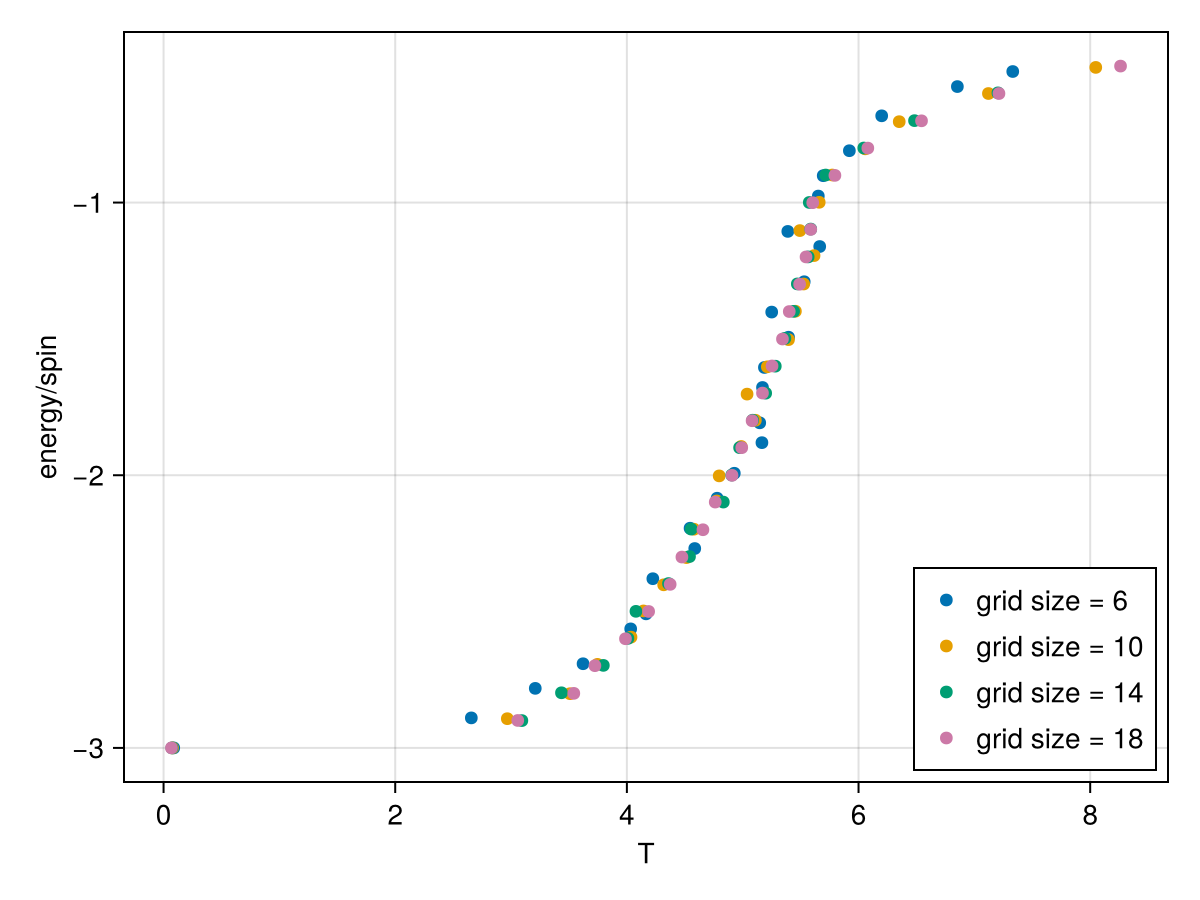

In [15]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="energy/spin")
for (t, e, grid_size) in zip( t_gs,e_gs, grid_sizes)
    plot!(ax, t, e, label="grid size = $grid_size")
end
axislegend(ax, position=:rb)
fig

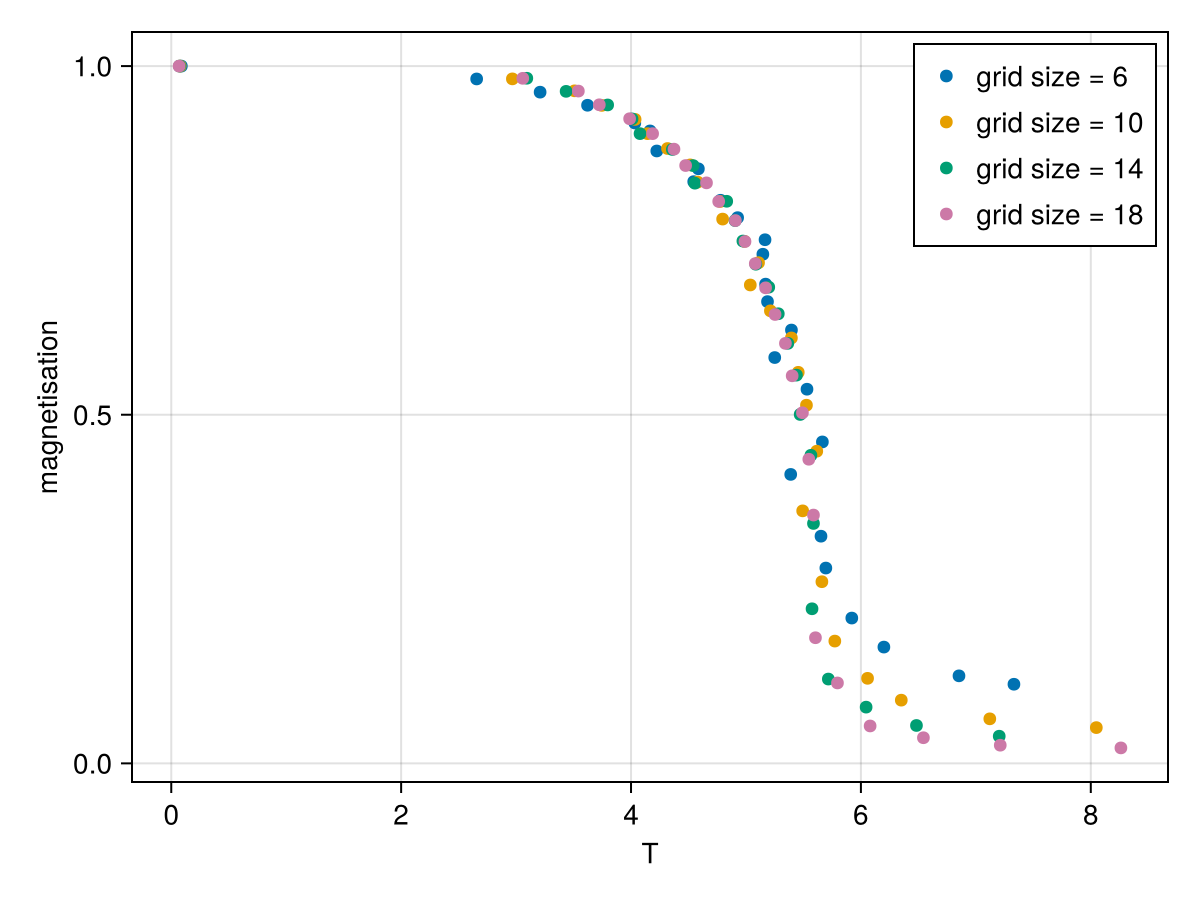

In [16]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="magnetisation")
for (t, m, grid_size) in zip(t_gs, m_gs, grid_sizes)
    plot!(ax,t, m, label="grid size = $grid_size")
end
axislegend(ax, position=:rt)
fig